In [1]:
import pandas as pd

# Part 1 specific
import sqlalchemy
from pathlib import Path

# Part 2 specific
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn import utils
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import tree
# ignore the warning you might get from importing ensemble from sklearn
from sklearn import ensemble


In [2]:
## create dataframes from csv data
players = pd.read_csv("/Users/HuyVu/Desktop/ChallengeLab/cl_repo/AmazoogleChallengeLab/pac12_2019_players.csv")
teams = pd.read_csv("/Users/HuyVu/Desktop/ChallengeLab/cl_repo/AmazoogleChallengeLab/pac12_2019_teams.csv")
all_teams = pd.read_csv("/Users/HuyVu/Desktop/ChallengeLab/cl_repo/AmazoogleChallengeLab//data/all_teams_2019.csv")

In [18]:
players.columns

Index(['Unnamed: 0', '_player_id', '_name', '_height', '_weight', '_position',
       '_season', '_team_abbreviation', '_minutes_played', '_total_rebounds',
       '_player_efficiency_rating', '_field_goal_percentage',
       '_free_throw_percentage', '_two_point_percentage',
       '_three_point_percentage', '_offensive_rebounds', '_assists',
       '_turnovers', '_usage_percentage', '_offensive_win_shares',
       '_defensive_rebounds', '_steals', '_blocks', '_defensive_win_shares'],
      dtype='object')

In [4]:
## Split up data into train and test splits
all_teams_train, all_teams_test = train_test_split(all_teams,test_size = 0.2,random_state = 100)

In [39]:
team_columns_wanted = ["abbreviation","name","conference","assists","blocks","field_goal_percentage","free_throw_percentage",
                   "free_throw_attempts","losses","net_rating","offensive_rating","offensive_rebounds",
                   "opp_assists","opp_field_goal_percentage","opp_offensive_rating","opp_three_point_field_goal_percentage",
                   "pace","points","three_point_field_goal_percentage","three_point_field_goal_attempts","total_rebounds",
                   "true_shooting_percentage","turnovers","turnover_percentage","two_point_field_goal_percentage","wins","win_percentage"
                  ]

team_columns_wanted_without_strings = team_columns_wanted[3:]
def get_desired_columns_from_df(df, columns_wanted):
    copied = df.copy()
    return copied[columns_wanted]

## Gets rid of the string valued columns and normalizes the data
def normalize_data(df):
    ## Select mean and std
    team_desc = df.describe().loc['mean':'std']
    team_means = team_desc.loc['mean']
    team_std = team_desc.loc['std']
    
    # teams_selected_columns.iloc[:,1:]
    values_useful = df.copy()
    values_useful.index = values_useful['abbreviation']
    values_useful = values_useful.drop(['abbreviation','name', 'conference'], axis=1)
    return (((values_useful - team_means) / team_std), team_means, team_std)

## normalizes the data, assuming the dataframe has no string values
def normalize_nonstring_data(df):
    ## Select mean and std
    team_desc = df.describe().loc['mean':'std']
    team_means = team_desc.loc['mean']
    team_std = team_desc.loc['std']
    
    # teams_selected_columns.iloc[:,1:]
    values_useful = df.copy()
    return (((values_useful - team_means) / team_std), team_means, team_std)




## Normalize the all team dataframe. Excludes the test teams

In [56]:
selected_cols_all_team = get_desired_columns_from_df(all_teams_train, team_columns_wanted)
normalized_all_team, all_team_mean, all_team_std = normalize_data(selected_cols_all_team)
normalized_all_team

,assists,blocks,field_goal_percentage,free_throw_percentage,free_throw_attempts,losses,net_rating,offensive_rating,offensive_rebounds,opp_assists,...,points,three_point_field_goal_percentage,three_point_field_goal_attempts,total_rebounds,true_shooting_percentage,turnovers,turnover_percentage,two_point_field_goal_percentage,wins,win_percentage
abbreviation,,,,,,,,,,,,,,,,,,,,,
CANISIUS,0.348961,-0.025602,-0.327632,-0.413294,-0.562519,0.217508,-0.822535,-0.387235,-0.461454,-0.473332,...,-0.577368,-0.791706,0.475287,-1.157678,-0.272610,-0.268197,0.141643,0.434384,-0.315906,-0.245107
MICHIGAN,1.008546,1.284160,0.199166,-0.154104,-0.523653,-1.754750,1.795980,0.491606,-0.477573,-1.006442,...,0.704476,-0.068268,0.902818,1.161717,0.026810,-1.843435,-2.249133,0.373877,2.057598,1.778093
ORAL-ROBERTS,-0.109880,-0.057547,0.523349,-0.442093,-1.368982,1.006411,-1.038847,0.095266,0.102717,1.089231,...,-0.324944,0.735553,-0.032406,-0.158935,0.288802,0.438640,0.783071,0.313370,-0.948841,-0.984580
LIBERTY,1.295322,-0.408946,1.779558,1.977009,-1.058057,-1.754750,1.978138,1.577234,-0.945029,-1.263805,...,1.016063,1.016890,1.205653,0.063925,2.047894,-0.611518,-0.616408,2.279844,1.899364,1.748514
BETHUNE-COOKMAN,0.033508,-0.025602,-0.165540,-2.774798,0.545154,0.217508,0.042713,-0.869737,1.392251,0.133310,...,-0.419603,-0.912280,-0.914189,0.889333,-1.021160,1.529189,1.307876,-0.231192,-0.474140,-0.345675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DREXEL,0.320284,-1.495090,0.685440,1.343435,-0.475071,0.611960,-0.424065,0.801786,-0.268024,0.059778,...,0.112855,0.414025,-0.611354,-0.332270,0.588222,-0.975035,-0.791343,0.343623,-0.632373,-0.617801
WICHITA-STATE,0.822142,0.836924,-1.421750,0.537068,0.214795,-0.176944,0.122407,-0.387235,1.988660,-0.032138,...,0.838577,-1.354381,1.357070,2.069666,-1.395435,0.418445,-0.849654,-1.048035,0.791729,0.500283
UTAH-VALLEY,0.607060,-0.632564,1.576944,0.537068,1.273886,-1.163073,0.862422,1.008572,-0.171309,0.556121,...,1.185661,1.539374,0.021035,0.864571,1.748474,1.246454,0.783071,1.160467,1.266430,1.204261


In [57]:
## sort by win percentage to find the teams with highest win percentage, as that will be our baseline reference
normalized_all_team.sort_values("win_percentage")

,assists,blocks,field_goal_percentage,free_throw_percentage,free_throw_attempts,losses,net_rating,offensive_rating,offensive_rebounds,opp_assists,...,points,three_point_field_goal_percentage,three_point_field_goal_attempts,total_rebounds,true_shooting_percentage,turnovers,turnover_percentage,two_point_field_goal_percentage,wins,win_percentage
abbreviation,,,,,,,,,,,,,,,,,,,,,
CHICAGO-STATE,-0.941530,-1.175636,-1.340704,-0.874075,-0.504221,2.584218,-3.828135,-3.127154,-1.235174,2.100301,...,-1.681727,-1.796482,-2.374920,-1.413554,-2.069129,1.751338,2.357485,-1.683358,-2.214709,-2.463527
SAN-JOSE-STATE,-0.267607,-1.814544,-1.583841,-1.478851,-0.125280,2.189766,-2.678265,-2.058758,-0.090713,2.026769,...,-1.397749,-0.630942,-0.860747,-0.299254,-1.694854,1.185868,1.657746,-1.743865,-2.056476,-2.256475
MAINE,0.420655,-0.472837,-0.449200,-1.680443,-1.757640,2.189766,-1.687784,-1.662418,-0.783838,1.070848,...,-1.610732,-1.314190,-0.807306,-1.248473,-1.096015,0.701180,1.716057,-0.019418,-1.898242,-2.096748
NEW-HAMPSHIRE,-1.672808,-1.782599,-2.718482,-2.774798,-2.408640,1.598089,-1.630859,-2.437866,-1.106221,-2.642537,...,-2.580990,-0.470178,0.439660,-1.487841,-2.518259,-1.399137,0.025020,-2.681722,-1.898242,-2.002096
KENNESAW-STATE,-1.142273,-0.089492,-2.515867,-0.326897,-0.416773,1.992540,-2.302565,-2.506795,0.699126,1.438510,...,-1.445078,-1.314190,-2.668848,-0.026870,-3.191954,0.236687,0.141643,-3.135523,-1.740009,-1.907443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WOFFORD,1.237967,-0.121438,1.901127,-0.067708,-0.543086,-2.149202,2.581535,2.680095,0.586292,-0.638780,...,1.903493,2.825487,1.704439,0.542662,2.122749,-0.975035,-1.549394,1.281480,2.057598,2.050219
BUFFALO,2.256021,0.996651,0.766486,-0.557288,1.303035,-2.346428,1.887059,1.577234,1.988660,-1.098357,...,2.526667,-0.269223,2.532781,2.507132,0.737932,0.155905,-1.374459,1.614268,2.374065,2.239524
GONZAGA,3.245398,3.041157,3.359950,1.573826,1.536229,-2.346428,3.446783,3.197060,0.408981,-1.263805,...,3.339159,0.775744,0.466380,2.284272,2.946153,-0.631714,-1.782640,3.278208,2.532299,2.257272


##  Create Linear Regression Models

### Linear Model 1

Training and fitting a Linear Regression model on the normalized team data

In [58]:
## Select columns for training data
training_columns_wanted = ["assists","blocks","field_goal_percentage","free_throw_percentage",
                       "free_throw_attempts","net_rating","offensive_rating","offensive_rebounds",
                       "opp_assists","opp_field_goal_percentage","opp_offensive_rating","opp_three_point_field_goal_percentage",
                       "pace","points","three_point_field_goal_percentage","three_point_field_goal_attempts","total_rebounds",
                       "true_shooting_percentage", 'turnovers', "turnover_percentage","two_point_field_goal_percentage"
                      ]

In [59]:
## Train on raw normalized data
on_normalized_data_model = LinearRegression()

## Grab training data
X_train = normalized_all_team[training_columns_wanted]
Y_train = normalized_all_team["wins"]

## Grab testing data
test_selected_columns = get_desired_columns_from_df(all_teams_test, team_columns_wanted)
X_predict, X_predict_mean,X_predict_std = normalize_data(test_selected_columns)
X_predict = X_predict[training_columns_wanted]

on_normalized_data_model.fit(X_train,Y_train)
on_normalzied_data_y_hat = on_normalized_data_model.predict(X_predict)

## Normalized the test data
normalized_y_true, normalized_test_mean, normalized_test_std = normalize_data(test_selected_columns)
normalized_y_true = normalized_y_true['wins']


MSE :  0.06732454617849598
MAE :  0.1969356597971974


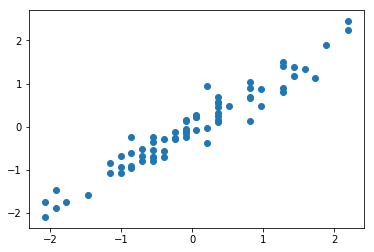

In [60]:
on_normalzied_data_mse = mean_squared_error(normalized_y_true, on_normalzied_data_y_hat)
on_normalzied_data_mae = mean_absolute_error(normalized_y_true, on_normalzied_data_y_hat)
plt.scatter(normalized_y_true, on_normalzied_data_y_hat)
print("MSE : ", on_normalzied_data_mse)
print("MAE : ", on_normalzied_data_mae)

### Linear Model 2

Training and fitting a Linear Regression model on the actual team data, named `all_teams_train`

In [61]:
not_normal_model = LinearRegression()

## Grab training data
train_selected_columns = get_desired_columns_from_df(all_teams_train, team_columns_wanted)
actual_X_train = train_selected_columns[training_columns_wanted]
actual_Y_train = train_selected_columns['wins']

## fit model to the raw data
not_normal_model.fit(actual_X_train, actual_Y_train)

## Grab testing data 
test_selected_columns = get_desired_columns_from_df(all_teams_test, team_columns_wanted)
not_normal_X_predict = test_selected_columns[training_columns_wanted]

not_normal_y_hat = not_normal_model.predict(not_normal_X_predict)
not_normal_y_true = test_selected_columns['wins']



MSE :  2.814501063020658
MAE :  1.3357762185529474


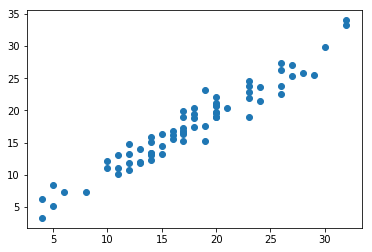

In [62]:
not_normal_mse = mean_squared_error(not_normal_y_true, not_normal_y_hat)
not_normal_mae = mean_absolute_error(not_normal_y_true, not_normal_y_hat)
plt.scatter(not_normal_y_true, not_normal_y_hat)
print("MSE : ", not_normal_mse)
print("MAE : ", not_normal_mae)

### Linear Model 3

Training and fitting a Linear Regression model on the actual team data, named `all_teams_train` weighted by the `correlation` to win percentage

In [106]:
attributes_for_correlation = ['assists', 'blocks', 'field_goal_percentage', 'free_throw_percentage',
       'free_throw_attempts', 'net_rating', 'offensive_rating',
       'offensive_rebounds', 'opp_assists', 'opp_field_goal_percentage',
       'opp_offensive_rating', 'opp_three_point_field_goal_percentage', 'pace',
       'points', 'three_point_field_goal_percentage',
       'three_point_field_goal_attempts', 'total_rebounds',
       'true_shooting_percentage', 'turnovers', 'turnover_percentage',
       'two_point_field_goal_percentage']

def correlation(t, x, y):
    ## ENSURE T IS ALREADY IN STD UNITS
    return np.mean(t[x]*t[y])



## Grab the actual training data
correlation_all_team = normalized_all_team.copy() ## Should already have no strings in data and includes wins/wins percentage
correlation_all_team_mean = all_team_mean
correlation_all_team_std = all_team_std 
correlation_actual_Y_train = correlation_all_team['wins']

## Grab the testing data and normalize it 
correlation_all_team_test = all_teams_test.copy()
correlation_selected_cols_all_team_test = get_desired_columns_from_df(correlation_all_team_test, team_columns_wanted)
correlation_normalized_all_test, correlation_all_test_mean, correlation_all_test_std = normalize_data(correlation_selected_cols_all_team_test)
correlation_normalized_all_test
correlation_actual_Y_test = correlation_normalized_all_test['wins']


## Modify the train and tet by the corresponding correlations and map to dictionary
## scaled_mapping is the correlations between each attribute and number of wins
scaled_mapping = {}
scales = []

print("Before correlation weighing")
display(correlation_all_team)
## With normalize data, multiply correlations to their corresponding columns to indicate how important that feature is
for att in attributes_for_correlation:
    ## calclate correlation
    att_correlation = correlation(correlation_all_team, att, 'wins')
    
    # Retaining correlation
    scales.append(att_correlation)
    scaled_mapping[att] = att_correlation
    
    ## Scale normal data by correlatoin
    correlation_all_team[att] = correlation_all_team[att] * att_correlation
    correlation_all_team_test[att] = correlation_all_team_test[att] * att_correlation

print("After correlation weighing")
## `correlation_all_team` now is a weighed version of the normalized data based on correlations
## with the wins
display(correlation_all_team)





# (team_selected_sorted - team_selected_sorted.describe().loc['mean']) / ((team_selected_sorted.describe().loc['std'])**2)

Before correlation weighing


,assists,blocks,field_goal_percentage,free_throw_percentage,free_throw_attempts,losses,net_rating,offensive_rating,offensive_rebounds,opp_assists,...,points,three_point_field_goal_percentage,three_point_field_goal_attempts,total_rebounds,true_shooting_percentage,turnovers,turnover_percentage,two_point_field_goal_percentage,wins,win_percentage
abbreviation,,,,,,,,,,,,,,,,,,,,,
CANISIUS,0.348961,-0.025602,-0.327632,-0.413294,-0.562519,0.217508,-0.822535,-0.387235,-0.461454,-0.473332,...,-0.577368,-0.791706,0.475287,-1.157678,-0.272610,-0.268197,0.141643,0.434384,-0.315906,-0.245107
MICHIGAN,1.008546,1.284160,0.199166,-0.154104,-0.523653,-1.754750,1.795980,0.491606,-0.477573,-1.006442,...,0.704476,-0.068268,0.902818,1.161717,0.026810,-1.843435,-2.249133,0.373877,2.057598,1.778093
ORAL-ROBERTS,-0.109880,-0.057547,0.523349,-0.442093,-1.368982,1.006411,-1.038847,0.095266,0.102717,1.089231,...,-0.324944,0.735553,-0.032406,-0.158935,0.288802,0.438640,0.783071,0.313370,-0.948841,-0.984580
LIBERTY,1.295322,-0.408946,1.779558,1.977009,-1.058057,-1.754750,1.978138,1.577234,-0.945029,-1.263805,...,1.016063,1.016890,1.205653,0.063925,2.047894,-0.611518,-0.616408,2.279844,1.899364,1.748514
BETHUNE-COOKMAN,0.033508,-0.025602,-0.165540,-2.774798,0.545154,0.217508,0.042713,-0.869737,1.392251,0.133310,...,-0.419603,-0.912280,-0.914189,0.889333,-1.021160,1.529189,1.307876,-0.231192,-0.474140,-0.345675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DREXEL,0.320284,-1.495090,0.685440,1.343435,-0.475071,0.611960,-0.424065,0.801786,-0.268024,0.059778,...,0.112855,0.414025,-0.611354,-0.332270,0.588222,-0.975035,-0.791343,0.343623,-0.632373,-0.617801
WICHITA-STATE,0.822142,0.836924,-1.421750,0.537068,0.214795,-0.176944,0.122407,-0.387235,1.988660,-0.032138,...,0.838577,-1.354381,1.357070,2.069666,-1.395435,0.418445,-0.849654,-1.048035,0.791729,0.500283
UTAH-VALLEY,0.607060,-0.632564,1.576944,0.537068,1.273886,-1.163073,0.862422,1.008572,-0.171309,0.556121,...,1.185661,1.539374,0.021035,0.864571,1.748474,1.246454,0.783071,1.160467,1.266430,1.204261


After correlation weighing


,assists,blocks,field_goal_percentage,free_throw_percentage,free_throw_attempts,losses,net_rating,offensive_rating,offensive_rebounds,opp_assists,...,points,three_point_field_goal_percentage,three_point_field_goal_attempts,total_rebounds,true_shooting_percentage,turnovers,turnover_percentage,two_point_field_goal_percentage,wins,win_percentage
abbreviation,,,,,,,,,,,,,,,,,,,,,
CANISIUS,0.232218,-0.011021,-0.195375,-0.096802,-0.232832,0.217508,-0.758131,-0.290444,-0.161950,0.099046,...,-0.448542,-0.278361,0.164674,-0.766280,-0.162434,0.014086,-0.064987,0.243462,-0.315906,-0.245107
MICHIGAN,0.671142,0.552785,0.118768,-0.036094,-0.216745,-1.754750,1.655356,0.368726,-0.167608,0.210600,...,0.547288,-0.024003,0.312803,0.768954,0.015975,0.096817,1.031913,0.209549,2.057598,1.778093
ORAL-ROBERTS,-0.073120,-0.024772,0.312086,-0.103547,-0.566636,1.006411,-0.957506,0.071454,0.036049,-0.227924,...,-0.252440,0.258618,-0.011228,-0.105201,0.172082,-0.023037,-0.359277,0.175637,-0.948841,-0.984580
LIBERTY,0.861978,-0.176037,1.061196,0.463054,-0.437940,-1.754750,1.823250,1.182995,-0.331664,0.264454,...,0.789352,0.357535,0.417727,0.042313,1.220231,0.032117,0.282811,1.277799,1.899364,1.748514
BETHUNE-COOKMAN,0.022298,-0.011021,-0.098716,-0.649912,0.225645,0.217508,0.039369,-0.652341,0.488620,-0.027895,...,-0.325978,-0.320754,-0.316742,0.588659,-0.608455,-0.080313,-0.600060,-0.129578,-0.474140,-0.345675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DREXEL,0.213134,-0.643583,0.408745,0.314659,-0.196637,0.611960,-0.390861,0.601374,-0.094065,-0.012509,...,0.087674,0.145570,-0.211818,-0.219934,0.350490,0.051209,0.363072,0.192593,-0.632373,-0.617801
WICHITA-STATE,0.547098,0.360266,-0.847826,0.125792,0.088906,-0.176944,0.112823,-0.290444,0.697933,0.006725,...,0.651467,-0.476196,0.470189,1.369935,-0.831465,-0.021977,0.389826,-0.587399,0.791729,0.500283
UTAH-VALLEY,0.403971,-0.272296,0.940372,0.125792,0.527274,-1.163073,0.794895,0.756473,-0.060122,-0.116370,...,0.921108,0.541238,0.007288,0.572269,1.041822,-0.065464,-0.359277,0.650414,1.266430,1.204261


In [104]:
correlated_model = LinearRegression()

## Grab the correlated data
corelated_X_train = correlation_all_team[training_columns_wanted]
corelated_Y_train = correlation_all_team["wins"]
correlated_model.fit(corelated_X_train, corelated_Y_train)

## Predict using the correlated normalized linear regression
correlated_X_predict = correlation_all_team_test[training_columns_wanted]

correlated_y_hat = correlated_model.predict(correlated_X_predict)

## Normalized the test data
# correlated_y_true, correlated_test_mean, correlated_test_std = normalize_data(correlation_normalized_all_test)
correlated_y_true = correlation_normalized_all_test['wins']



MSE :  34099151.19118768
MAE :  5817.474724954136


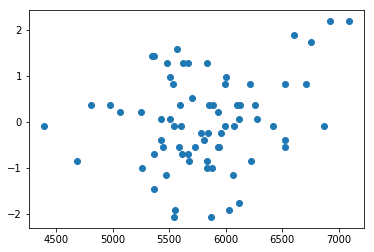

In [105]:
correlated_normal_mse = mean_squared_error(correlated_y_hat, correlated_y_true)
correlated_normal_mae = mean_absolute_error(correlated_y_hat, correlated_y_true)
plt.scatter(correlated_y_hat, correlated_y_true)
print("MSE : ", correlated_normal_mse)
print("MAE : ", correlated_normal_mae)

In [99]:
scaled_mapping
correlation_all_team_test
correlation_all_team

,assists,blocks,field_goal_percentage,free_throw_percentage,free_throw_attempts,losses,net_rating,offensive_rating,offensive_rebounds,opp_assists,...,points,three_point_field_goal_percentage,three_point_field_goal_attempts,total_rebounds,true_shooting_percentage,turnovers,turnover_percentage,two_point_field_goal_percentage,wins,win_percentage
abbreviation,,,,,,,,,,,,,,,,,,,,,
CANISIUS,0.232218,-0.011021,-0.195375,-0.096802,-0.232832,0.217508,-0.758131,-0.290444,-0.161950,0.099046,...,-0.448542,-0.278361,0.164674,-0.766280,-0.162434,0.014086,-0.064987,0.243462,-0.315906,-0.245107
MICHIGAN,0.671142,0.552785,0.118768,-0.036094,-0.216745,-1.754750,1.655356,0.368726,-0.167608,0.210600,...,0.547288,-0.024003,0.312803,0.768954,0.015975,0.096817,1.031913,0.209549,2.057598,1.778093
ORAL-ROBERTS,-0.073120,-0.024772,0.312086,-0.103547,-0.566636,1.006411,-0.957506,0.071454,0.036049,-0.227924,...,-0.252440,0.258618,-0.011228,-0.105201,0.172082,-0.023037,-0.359277,0.175637,-0.948841,-0.984580
LIBERTY,0.861978,-0.176037,1.061196,0.463054,-0.437940,-1.754750,1.823250,1.182995,-0.331664,0.264454,...,0.789352,0.357535,0.417727,0.042313,1.220231,0.032117,0.282811,1.277799,1.899364,1.748514
BETHUNE-COOKMAN,0.022298,-0.011021,-0.098716,-0.649912,0.225645,0.217508,0.039369,-0.652341,0.488620,-0.027895,...,-0.325978,-0.320754,-0.316742,0.588659,-0.608455,-0.080313,-0.600060,-0.129578,-0.474140,-0.345675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DREXEL,0.213134,-0.643583,0.408745,0.314659,-0.196637,0.611960,-0.390861,0.601374,-0.094065,-0.012509,...,0.087674,0.145570,-0.211818,-0.219934,0.350490,0.051209,0.363072,0.192593,-0.632373,-0.617801
WICHITA-STATE,0.547098,0.360266,-0.847826,0.125792,0.088906,-0.176944,0.112823,-0.290444,0.697933,0.006725,...,0.651467,-0.476196,0.470189,1.369935,-0.831465,-0.021977,0.389826,-0.587399,0.791729,0.500283
UTAH-VALLEY,0.403971,-0.272296,0.940372,0.125792,0.527274,-1.163073,0.794895,0.756473,-0.060122,-0.116370,...,0.921108,0.541238,0.007288,0.572269,1.041822,-0.065464,-0.359277,0.650414,1.266430,1.204261


In [85]:
correlation_normalized_all_test

,assists,blocks,field_goal_percentage,free_throw_percentage,free_throw_attempts,losses,net_rating,offensive_rating,offensive_rebounds,opp_assists,...,points,three_point_field_goal_percentage,three_point_field_goal_attempts,total_rebounds,true_shooting_percentage,turnovers,turnover_percentage,two_point_field_goal_percentage,wins,win_percentage
abbreviation,,,,,,,,,,,,,,,,,,,,,
OKLAHOMA,-0.256322,-0.359228,0.185396,-0.211725,-0.097864,-0.366164,0.306702,-0.195207,-0.459182,-0.206183,...,0.028077,-0.034729,-0.790262,0.644689,-0.284027,-0.657818,-0.681117,-0.231220,0.364837,0.405116
CENTRAL-FLORIDA,-0.133357,0.805613,0.952180,-1.348041,1.580927,-1.350922,1.100612,0.543757,-0.292078,-0.546097,...,-0.104588,0.733295,-0.994521,0.259975,0.545699,-0.830799,-0.421121,0.489358,0.974330,1.218895
TEXAS-CHRISTIAN,2.039029,1.096823,0.611387,-0.566824,0.554999,-0.366164,0.476825,0.198907,1.044751,3.034334,...,1.099872,-0.034729,0.458865,1.317938,0.184948,1.461208,0.202870,0.583346,0.821956,0.604170
CALIFORNIA-RIVERSIDE,-0.324636,-1.378463,0.015000,-0.519478,-1.907227,1.406401,-0.872822,-0.425107,-0.776679,0.269697,...,-0.914544,1.177941,-0.091065,-1.054463,-0.031502,-0.138873,0.670864,-0.419197,-1.158894,-1.263422
GRAMBLING,-0.392950,0.732810,0.398392,-0.495804,1.422374,0.224691,0.215969,-0.753535,-0.425761,-0.636741,...,0.038551,2.269343,-1.583732,0.837046,0.184948,2.261248,1.658850,-0.983128,-0.092282,-0.110082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RIDER,0.016934,-0.383495,0.185396,-2.129258,1.179882,-0.169212,0.034504,-0.080257,0.510019,0.836221,...,-0.118553,-0.236841,-0.813830,-0.309080,-0.464403,-0.355100,-0.369122,-0.043244,-0.244655,-0.016409
SOUTH-ALABAMA,0.303853,0.587205,0.739185,-0.472131,0.377794,0.224691,-0.146961,0.149643,-0.743258,0.722917,...,0.220092,1.137518,0.050346,-0.709824,0.762149,0.531431,0.462867,0.458028,-0.092282,-0.110082
BROWN,-0.420276,0.150390,0.015000,0.214393,0.527019,-0.760067,0.522192,-0.507214,-1.194438,-0.953994,...,-0.209324,-0.196418,-0.075353,-0.204887,0.257098,0.574677,0.670864,0.270051,0.364837,0.621734


In [ ]:
attributes_for_correlation = [ 'field_goal_percentage', 'free_throw_percentage',
     'net_rating', 'offensive_rating',
     'opp_field_goal_percentage', 'opp_three_point_field_goal_percentage', 'pace',
       'points', 'three_point_field_goal_percentage',
       'true_shooting_percentage', 'turnover_percentage',"turnovers",
       'two_point_field_goal_percentage', 'wins', 'win_percentage',
       'assists_per game', 'blocks_per game', 'free_throw_attempts_per game',
       'offensive_rebounds_per game', 'opp_assists_per game',
       'points_per game', 'three_point_field_goal_attempts_per game','turnovers_per game',
       'total_rebounds_per game']


def correlation(t, x, y):
    ## ENSURE T IS ALREADY IN STD UNITS
    return np.mean(t[x]*t[y])

copied_X_train = X_train.copy()

for att in attributes_for_correlation:
#     att_correlation = correlation(copied_X_train, att, 'wins')
    att_correlation =  scaled_mapping[att]
#     scales.append(att_correlation)
    try:
        copied_X_train[att] = copied_X_train[att] * att_correlation
    except:
        print(att)
#     scaled_mapping[att] = att_correlation

scaled_model= LinearRegression()

scaled_model.fit(copied_X_train,Y_train)

scaled_model_y_hat = scaled_model.predict(X_predict)
y_true,test_mean,test_std = normalize_data(test_selected_columns)
y_true = y_true['wins']
    
# (team_selected_sorted - team_selected_sorted.describe().loc['mean']) / ((team_selected_sorted.describe().loc['std'])**2)

In [ ]:
scaled_model_mse = mean_squared_error(y_true,scaled_model_y_hat)
scaled_model_mae = mean_absolute_error(y_true,scaled_model_y_hat)
plt.scatter(y_true, scaled_model_y_hat)
print("MSE : ", scaled_model_mse)
print("MAE : ",scaled_model_mae)

In [ ]:
(y_true * all_team_std['win_percentage']) + all_team_mean['win_percentage']

In [ ]:
(y_hat * all_team_std['win_percentage']) + all_team_mean['win_percentage']

In [ ]:
not_normal_model = LinearRegression()
team_selected_columns = get_desired_columns_from_df(all_teams_train,team_columns_wanted)
X_train2 = team_selected_columns[training_columns_wanted]
Y_train2 = team_selected_columns['wins']

not_normal_model.fit(X_train2,Y_train2)
test_selected_columns = get_desired_columns_from_df(all_teams_test,team_columns_wanted)
X_predict2 = test_selected_columns[training_columns_wanted]

y_hat2 = not_normal_model.predict(X_predict2)
y_true2 = test_selected_columns['wins']


In [ ]:
mse2 = mean_squared_error(y_true2,y_hat2)
mae2 = mean_absolute_error(y_true2,y_hat2)
plt.scatter(y_true2, y_hat2)
print("MSE : ", mse2)
print("MAE : ",mae2)

In [ ]:
attribute_scales_dict = {}
def change_to_per_game(df, num_of_games):
    attributes = ['assists', 'blocks','free_throw_attempts',
       'offensive_rebounds', 'opp_assists',
       'points', 'three_point_field_goal_attempts', 'total_rebounds',"turnovers"]
    copied = df.copy()
    copied.index = copied['abbreviation']
    added_columns = []
    for attribute in attributes:
        new_col = attribute + "_per game"
        added_columns.append(new_col)
        copied[new_col] = copied[attribute] / num_of_games
#     copied = copied.drop(attributes,axis = 1)
    return copied, added_columns

In [ ]:
team_selected_stats_per_game, newly_added_columns = change_to_per_game(team_selected_columns,27)
without_string_teams = team_selected_stats_per_game[without_strings+newly_added_columns]


In [ ]:
## select top 14 teams as optimal
team_selected_sorted = without_string_teams.sort_values("win_percentage",ascending = False)
top_5 = team_selected_sorted.iloc[:14,:]
top_5_mean = top_5.describe().loc['mean']
top_5_std = top_5.describe().loc['std']

comparison_stats = without_string_teams - top_5_mean
comparison_stats.sort_values("win_percentage",ascending = False)

In [ ]:
comparison_stats.columns


In [ ]:
comparison_stats.sort_values("win_percentage",ascending = False).iloc[:14,:]

In [ ]:
top_5_mean

In [ ]:
top_5

In [ ]:
attributes_for_correlation = [ 'field_goal_percentage', 'free_throw_percentage',
     'net_rating', 'offensive_rating',
     'opp_field_goal_percentage', 'opp_three_point_field_goal_percentage', 'pace',
       'points', 'three_point_field_goal_percentage',
       'true_shooting_percentage', 'turnover_percentage',"turnovers",
       'two_point_field_goal_percentage', 'wins', 'win_percentage',
       'assists_per game', 'blocks_per game', 'free_throw_attempts_per game',
       'offensive_rebounds_per game', 'opp_assists_per game',
       'points_per game', 'three_point_field_goal_attempts_per game','turnovers_per game',
       'total_rebounds_per game']

def correlation(t, x, y):
    ## ENSURE T IS ALREADY IN STD UNITS
    return np.mean(t[x]*t[y])

scaled_mapping = {}
scales = []
team_selected_sorted
for att in attributes_for_correlation:
    normaled, mean_of_att, std_of_att = normalize_nonstring_data(team_selected_sorted)
    
    att_correlation = correlation(normaled, att, 'wins')
    scales.append(att_correlation)
    scaled_mapping[att] = att_correlation
    
# (team_selected_sorted - team_selected_sorted.describe().loc['mean']) / ((team_selected_sorted.describe().loc['std'])**2)

In [ ]:
# pd.DataFrame(scaled_mapping)
single ={"map":scaled_mapping}
column_correlations_vs_wins = pd.DataFrame(single)
column_correlations_vs_wins = column_correlations_vs_wins.sort_values("map",ascending = False)

# so = list(scaled_mapping.values()).sort()
# so

In [ ]:
column_correlations_vs_wins